## Fashion-MNIST-based simulated production line prediction
<font color=#FF0000>Description, TO BE DONE!!</font>

### Packages import

In [38]:
# necessary packages
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import pause

# import custom functions
from util.data_generate import *
from util.data_io import *
from model.CNN import *
from model.FCN import *

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [39]:
# apply CUDA
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


### Custom data loading

In [40]:
# Customize dataset
class ProductLineDataset(Dataset):
    def __init__(self, image: torch.Tensor, gt: torch.Tensor):
        self.x = image.reshape(len(image), 1, 28*3, 28*4).type(torch.float32)
        self.y = gt.type(torch.float32)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [41]:
# define file names
CSV_NAME_TRAIN_02346 = 'train_02346.csv'
CSV_NAME_TEST_02346 = 'test_02346.csv'
CSV_NAME_TEST_579 = 'test_579.csv'
CSV_NAME_TEST_18 = 'test_18.csv'
IMAGE_NAME_TRAIN_02346 = 'train_02346'
IMAGE_NAME_TEST_02346 = 'test_02346'
IMAGE_NAME_TEST_579 = 'test_579'
IMAGE_NAME_TEST_18 = 'test_18'

# import data
# 1-D ground truth
gt_train_02346 = gt_import(CSV_NAME_TRAIN_02346)
gt_test_02346 = gt_import(CSV_NAME_TEST_02346)
gt_test_579 = gt_import(CSV_NAME_TEST_579)
gt_test_18 = gt_import(CSV_NAME_TEST_18)

# 2-D ground truth
gt_train_02346 = torch.cat((gt_train_02346.reshape(len(gt_train_02346), 1), torch.zeros(len(gt_train_02346), 1)), dim = 1)
gt_test_02346 = torch.cat((gt_test_02346.reshape(len(gt_test_02346), 1), torch.zeros(len(gt_test_02346), 1)), dim = 1)
gt_test_579 = torch.cat((gt_test_579.reshape(len(gt_test_579), 1), torch.zeros(len(gt_test_579), 1)), dim = 1)
gt_test_18 = torch.cat((gt_test_18.reshape(len(gt_test_18), 1), torch.zeros(len(gt_test_18), 1)), dim = 1)

# 4-D image data
image_train_02346 = image_import(gt_train_02346, IMAGE_NAME_TRAIN_02346)/255.
image_test_02346 = image_import(gt_test_02346, IMAGE_NAME_TEST_02346)/255.
image_test_579 = image_import(gt_test_579, IMAGE_NAME_TEST_579)/255.
image_test_18 = image_import(gt_test_18, IMAGE_NAME_TEST_18)/255.

torch.Size([4224, 2])
torch.Size([4224, 1, 84, 112])


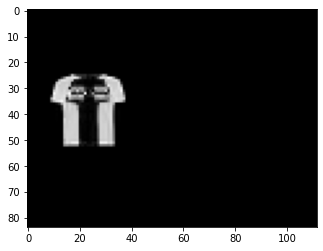

In [42]:
# print shapes
print(gt_train_02346.shape)
print(image_train_02346.shape)

# print info
plt.imshow(image_train_02346[1][0], cmap='gray')

In [43]:
# define dataset
dataset_train_02346 = ProductLineDataset(image_train_02346, gt_train_02346)
dataset_test_02346 = ProductLineDataset(image_test_02346, gt_test_02346)
dataset_test_579 = ProductLineDataset(image_test_579, gt_test_579)
dataset_test_18 = ProductLineDataset(image_test_18, gt_test_18)

# define dataloader
dataloader_train_02346 = DataLoader(dataset_train_02346, batch_size=512, shuffle=True)
dataloader_test_02346 = DataLoader(dataset_test_02346, batch_size=1, shuffle=False)  # batch_size=1 for accuracy calculation
dataloader_test_579 = DataLoader(dataset_test_579, batch_size=1, shuffle=False)
dataloader_test_18 = DataLoader(dataset_test_18, batch_size=1, shuffle=False)

In [44]:
# visualize the shape
for X, y in dataloader_train_02346:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape)
    print("Data type of y: ", y.dtype)
    print(y)
    break

Shape of X [N, C, H, W]:  torch.Size([512, 1, 84, 112])
Shape of y:  torch.Size([512, 2])
Data type of y:  torch.float32
tensor([[6., 0.],
        [6., 0.],
        [6., 0.],
        ...,
        [5., 0.],
        [3., 0.],
        [4., 0.]])


### Define functions

In [8]:
# define functions 
def train(model, dataloader_train, loss_fn, optimizer):   # put epoch in main better for loss calculation
    # initialize training loss
    train_loss = 0
    
    # size of dataset
    size = len(dataloader_train.dataset)
    
    # set model mode
    model.train()
    
    # train batches per epoch
    for batch, (X, y) in enumerate(dataloader_train):
        # move data to device
        X, y = X.to(device), y.to(device)
        
        score = model(X)
        # loss = torch.sum(torch.pow((score-y), 2) * torch.tensor([0.7, 0.3]).to(device)) / len(score)
        loss = loss_fn(score, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

    # calculate the average loss and accuracy
    train_loss /= batch
    print(f"Avg training loss: {train_loss:>8f}")
            
    return train_loss
            
def test(model, dataloader, loss_fn):
    # size of dataset
    size = len(dataloader.dataset)
    
    # number of batches
    num_batches = len(dataloader)
    
    # set model mode
    model.eval()
    
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X,y in dataloader:
            # move data to device
            X, y = X.to(device), y.to(device)
            
            score = model(X)
            # test_loss += (torch.sum(torch.pow((score-y), 2) * torch.tensor([0.7, 0.3]).to(device)) / len(score)).item()
            test_loss += loss_fn(score, y).item()
            if round(score[0][0].item() - y[0][0].item()) == 0: # only for batch_size=1
                correct += 1   
            else:
                correct += 0
    
    # calculate the average loss and accuracy
    test_loss /= num_batches
    correct /= num_batches
    print(f"Avg testing loss: {test_loss:>8f}, Accuracy: {(100*correct):>0.1f}%")
    
    return test_loss 

### FCN model setup and train/test

In [97]:
in_channel = (28*3)*(28*4)
node_1 = 4096
node_2 = 1024
node_3 = 256
node_4 = 64
node_5 = 16
node_6 = 8
out_channel = 2

FCN_model = FCN(in_channel, node_1, node_2, node_3, node_4, \
    node_5, node_6, out_channel).to(device=device)
print(FCN_model)

FCN(
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9408, out_features=4096, bias=True)
    (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (fc3): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (fc4): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (fc5): Sequential(

In [98]:
# define parameters
learning_rate = 1e-3

# define lose function
loss_fn = nn.MSELoss()

# define optimizer
optimizer_FCN = torch.optim.Adam(FCN_model.parameters(), lr=learning_rate)

Epoch 1
-------------------------------
Avg training loss: 12.723230
Avg testing loss: 10.962766, Accuracy: 0.0%
Epoch 2
-------------------------------
Avg training loss: 11.299959
Avg testing loss: 9.664968, Accuracy: 0.0%
Epoch 3
-------------------------------
Avg training loss: 10.223076
Avg testing loss: 8.773738, Accuracy: 0.0%
Epoch 4
-------------------------------
Avg training loss: 8.899047
Avg testing loss: 7.987892, Accuracy: 0.0%
Epoch 5
-------------------------------
Avg training loss: 7.322917
Avg testing loss: 6.905717, Accuracy: 0.0%
Epoch 6
-------------------------------
Avg training loss: 5.567581
Avg testing loss: 5.809088, Accuracy: 0.0%
Epoch 7
-------------------------------
Avg training loss: 3.669071
Avg testing loss: 4.354408, Accuracy: 0.6%
Epoch 8
-------------------------------
Avg training loss: 2.030766
Avg testing loss: 2.868506, Accuracy: 13.2%
Epoch 9
-------------------------------
Avg training loss: 1.074692
Avg testing loss: 1.632699, Accuracy: 2

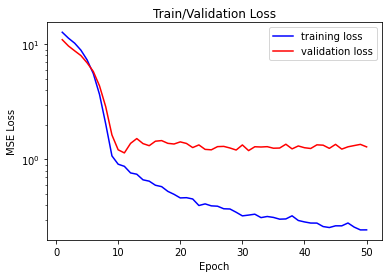

Save model with minimum loss:  11  epoch


In [99]:
# set epoch
epoch = 50
loss_train = []
loss_val = []
model_save = []

# train epoch
for t in range(epoch):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_train.append(train(FCN_model, dataloader_train_02346, loss_fn, optimizer_FCN)) # train with loss record
    loss_val.append(test(FCN_model, dataloader_test_579, loss_fn)) # test with loss record
    model_save.append(FCN_model) # save model in array
print("Done!!")

# print loss
loss_train = np.array(loss_train).flatten() # transform to np.array and flatten
loss_val = np.array(loss_val).flatten()     # transform to np.array and flatten
x = range(1, epoch+1)
plt.semilogy(x, loss_train, 'b-', label="training loss")
plt.semilogy(x, loss_val, 'r-', label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train/Validation Loss")
plt.legend()
plt.show()


# model saving
min = np.argmin(loss_val) # find the minimum loss
print("Save model with minimum loss: ", min+1, " epoch")
torch.save(model_save[min], "FCN.pt")

### CNN model setup and train/test

In [79]:
in_channel = 1
channel_1 = 16
channel_2 = 16
channel_3 = 32
channel_4 = 32
channel_5 = 64
node_1 = 2048
node_2 = 512
node_3 = 128
node_4 = 32
out_channel = 2

CNN_model = CNN(in_channel, channel_1, channel_2, channel_3, channel_4, channel_5, \
    node_1, node_2, node_3, node_4, out_channel).to(device=device)
print(CNN_model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, 

In [80]:
# define parameters
learning_rate = 1e-3

# define lose function
loss_fn = nn.MSELoss()

# define optimizer
optimizer_CNN = torch.optim.Adam(CNN_model.parameters(), lr=learning_rate)

Epoch 1
-------------------------------
Avg training loss: 4.241097
Avg testing loss: 4.137941, Accuracy: 0.0%
Epoch 2
-------------------------------
Avg training loss: 0.697958
Avg testing loss: 2.676241, Accuracy: 18.1%
Epoch 3
-------------------------------
Avg training loss: 0.448716
Avg testing loss: 1.546155, Accuracy: 17.2%
Epoch 4
-------------------------------
Avg training loss: 0.312771
Avg testing loss: 0.619813, Accuracy: 21.7%
Epoch 5
-------------------------------
Avg training loss: 0.271704
Avg testing loss: 1.036899, Accuracy: 14.8%
Epoch 6
-------------------------------
Avg training loss: 0.231427
Avg testing loss: 0.296385, Accuracy: 53.5%
Epoch 7
-------------------------------
Avg training loss: 0.185836
Avg testing loss: 0.344632, Accuracy: 44.8%
Epoch 8
-------------------------------
Avg training loss: 0.138976
Avg testing loss: 0.487455, Accuracy: 36.3%
Epoch 9
-------------------------------
Avg training loss: 0.131468
Avg testing loss: 0.354777, Accuracy:

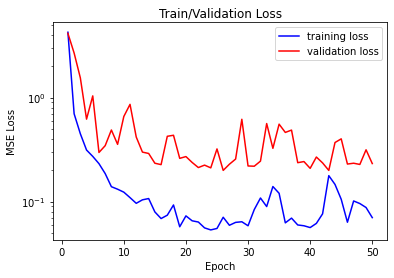

Save model with minimum loss:  43  epoch


In [81]:
# set epoch
epoch = 50
loss_train = []
loss_val = []
model_save = []

# train epoch
for t in range(epoch):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_train.append(train(CNN_model, dataloader_train_02346, loss_fn, optimizer_CNN)) # train with loss record
    loss_val.append(test(CNN_model, dataloader_test_02346, loss_fn)) # test with loss record
    model_save.append(CNN_model) # save model in array
print("Done!!")

# print loss
loss_train = np.array(loss_train).flatten() # transform to np.array and flatten
loss_val = np.array(loss_val).flatten()     # transform to np.array and flatten
x = range(1, epoch+1)
plt.semilogy(x, loss_train, 'b-', label="training loss")
plt.semilogy(x, loss_val, 'r-', label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train/Validation Loss")
plt.legend()
plt.show()

# model saving
min = np.argmin(loss_val) # find the minimum loss
print("Save model with minimum loss: ", min+1, " epoch")
torch.save(model_save[min], "CNN.pt")

### Prediction visualization

torch.Size([1026, 1, 84, 112])


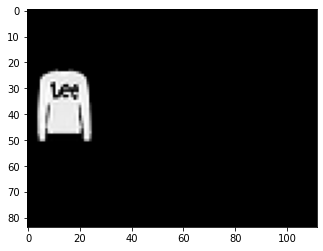

In [45]:
# raw data loading
IMAGE_NAME_TEST_02346_RAW = 'test_02346_raw'
image_test_02346_raw = image_import(gt_test_02346, IMAGE_NAME_TEST_02346_RAW)/255.
print(image_test_02346_raw.shape)
# print info
plt.imshow(image_test_02346_raw[2][0], cmap='gray')

In [46]:
# model loading
PATH_CNN = os.path.join(os.getcwd(), "CNN.pt")
FCN_model_trained = torch.load(PATH_CNN, map_location='cpu')

prediction = FCN_model_trained(image_test_02346)

print(prediction[:20])
print(gt_test_02346[:20])

tensor([[ 4.8818e+00, -2.5292e-03],
        [ 4.9139e+00, -2.1483e-03],
        [ 4.9347e+00, -2.1147e-03],
        [ 5.0389e+00, -1.5663e-03],
        [ 5.0853e+00, -1.4738e-03],
        [ 4.9024e+00, -2.7360e-03],
        [ 4.9685e+00, -2.8224e-03],
        [ 5.0467e+00, -2.2151e-03],
        [ 5.1773e+00, -1.1223e-03],
        [ 4.9718e+00, -2.1849e-03],
        [ 4.9263e+00, -2.0923e-03],
        [ 5.2065e+00, -2.6430e-04],
        [ 5.2370e+00, -4.4435e-05],
        [ 4.9795e+00, -1.5624e-03],
        [ 5.0707e+00, -1.4276e-03],
        [ 5.1503e+00, -1.4962e-03],
        [ 5.1732e+00, -1.5312e-03],
        [ 4.9218e+00, -3.1027e-03],
        [ 4.9208e+00, -2.9968e-03],
        [ 5.0553e+00, -1.4998e-03]], grad_fn=<SliceBackward>)
tensor([[5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
  

In [47]:
# round prediction to integer (pixel number)
x1 = prediction[:20].round().int()
print("prediction =", x1)
print("ground truth =", gt_test_02346[:20])

prediction = tensor([[5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0]], dtype=torch.int32)
ground truth = tensor([[5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.]])


In [48]:
# round prediction to integer (pixel number)
x2 = prediction[20:40].round().int()
print("prediction =", x2)
print("ground truth =", gt_test_02346[20:40])

prediction = tensor([[5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0]], dtype=torch.int32)
ground truth = tensor([[5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.]])


In [49]:
# round prediction to integer (pixel number)
x3 = prediction[40:59].round().int()
print("prediction =", x3)
print("ground truth =", gt_test_02346[40:59])

prediction = tensor([[5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0]], dtype=torch.int32)
ground truth = tensor([[5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.]])


In [50]:
# round prediction to integer (pixel number)
x4 = prediction[59:78].round().int()
print("prediction =", x4)
print("ground truth =", gt_test_02346[59:78])

prediction = tensor([[6, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0]], dtype=torch.int32)
ground truth = tensor([[5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.]])


In [51]:
# round prediction to integer (pixel number)
x5 = prediction[78:97].round().int()
print("prediction =", x5)
print("ground truth =", gt_test_02346[78:97])

prediction = tensor([[5, 0],
        [6, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [5, 0]], dtype=torch.int32)
ground truth = tensor([[5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.],
        [5., 0.]])


In [52]:
# round prediction to integer (pixel number)
x6 = prediction[97:122].round().int()
print("prediction =", x6)
print("ground truth =", gt_test_02346[97:122])

prediction = tensor([[4, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [3, 0]], dtype=torch.int32)
ground truth = tensor([[4., 0.],
        [4., 0.],
        [4., 0.],
        [4., 0.],
        [4., 0.],
        [4., 0.],
        [4., 0.],
        [4., 0.],
        [4., 0.],
        [4., 0.],
        [4., 0.],
        [4., 0.],
        [4., 0.],
        [4., 0.],
        [4., 0.],
        [4., 0.],
        [4., 0.],
        [4., 0.],
        [4., 0.],
        [4., 0.],
        [4., 0.],
        [4., 0.],
        [4., 0.],
        [4., 0.],
        [4., 0.]])


### Draw the results with bounding boxes

In [92]:
import cv2

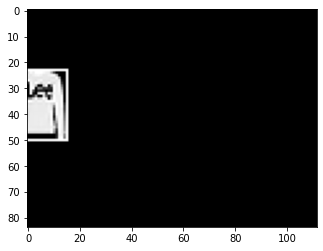

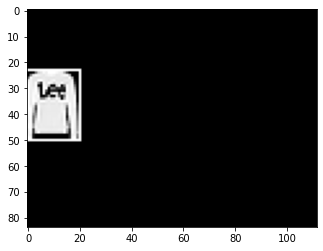

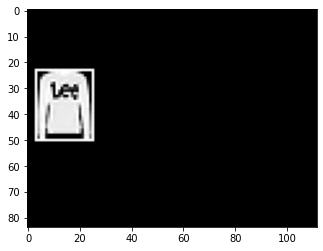

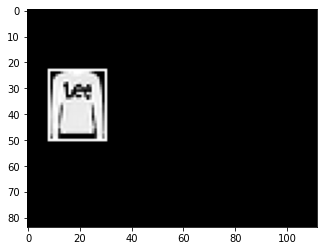

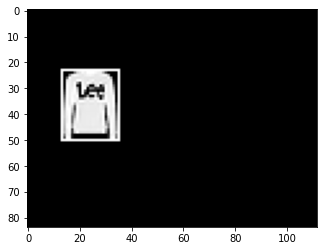

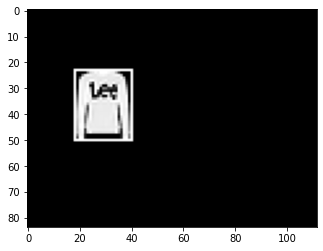

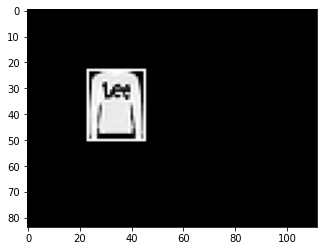

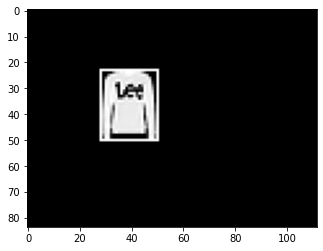

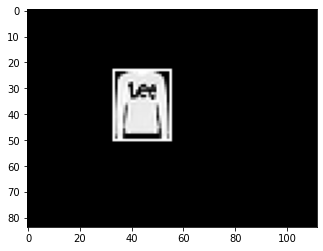

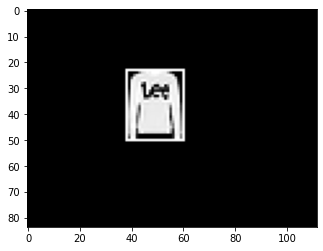

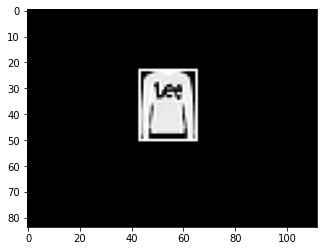

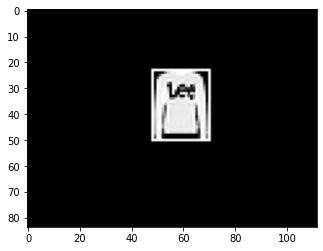

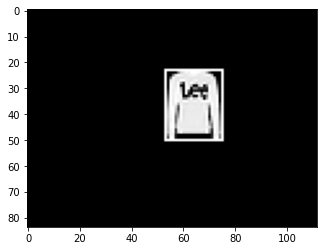

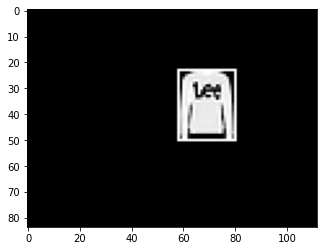

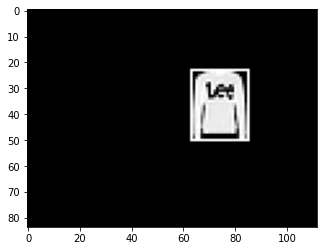

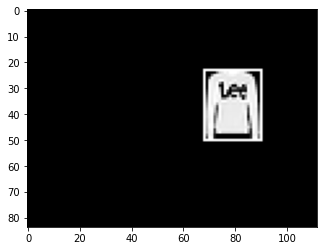

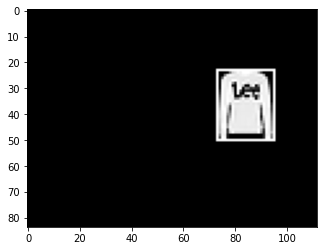

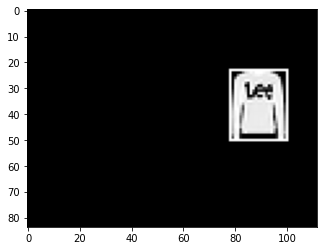

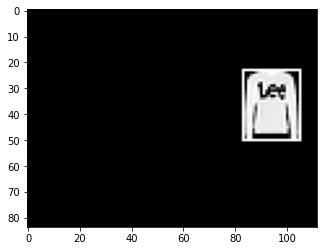

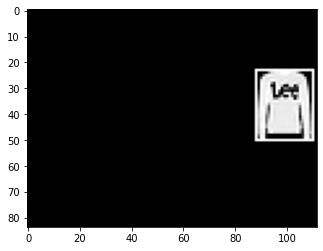

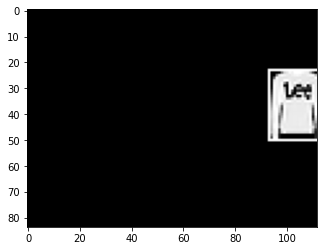

In [96]:
# 1st item (0~19)
start_point = 0

# load raw image data
image_test_02346_raw = image_import(gt_test_02346, IMAGE_NAME_TEST_02346_RAW)/255.

# initial image with bounding box
x_tl = -7
y_tl = 23
x_br = 15
y_br = 50
img = image_test_02346_raw[start_point][0].cpu().detach().numpy()
cv2.rectangle(img,(x_tl, y_tl),(x_br,y_br),(1,0,0),1)
plt.imshow(img, cmap='gray')
pause(0.1)

# updated image with bounding box
for i in range(20):
    # update bounding box position
    x_tl += x1[i][0].cpu().detach().item()
    y_tl += x1[i][1].cpu().detach().item()
    x_br += x1[i][0].cpu().detach().item()
    y_br += x1[i][1].cpu().detach().item()
    # plot img with bounding box
    img = image_test_02346_raw[start_point+i+1][0].cpu().detach().numpy()
    cv2.rectangle(img,(x_tl, y_tl),(x_br,y_br),(1,0,0),1)
    plt.imshow(img, cmap='gray')
    pause(0.1)

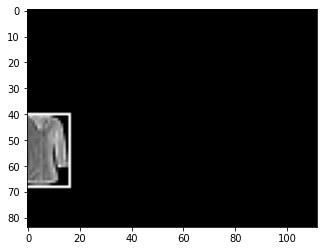

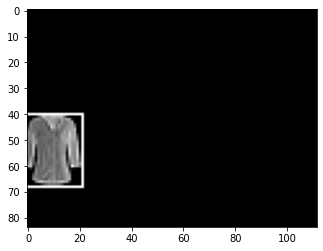

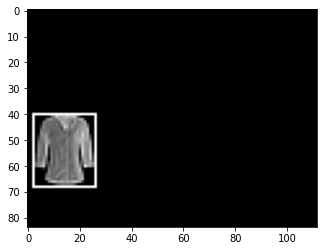

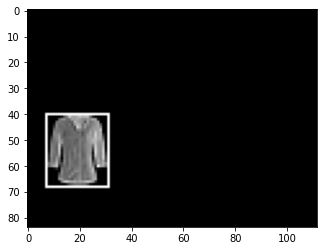

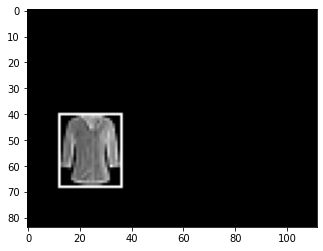

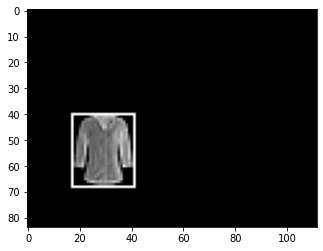

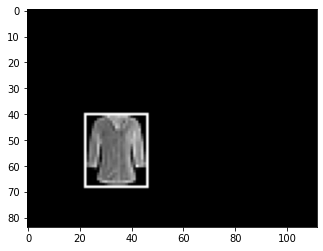

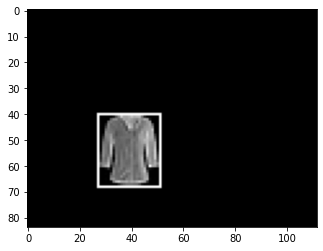

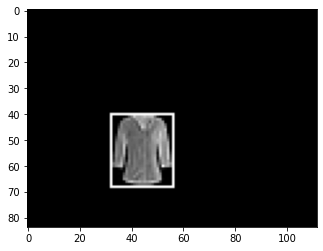

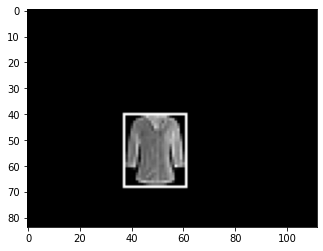

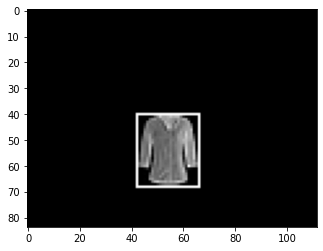

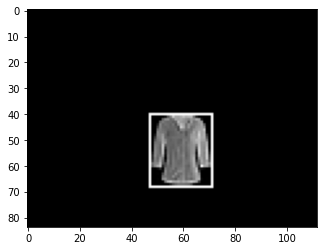

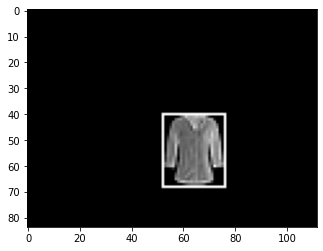

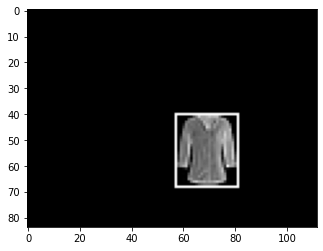

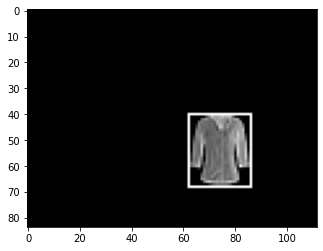

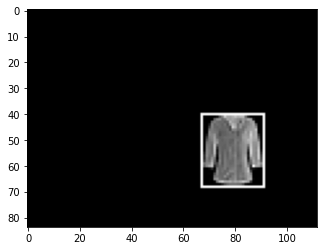

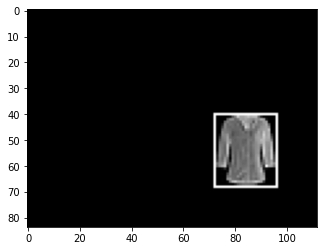

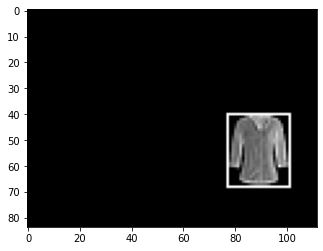

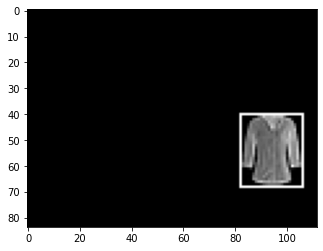

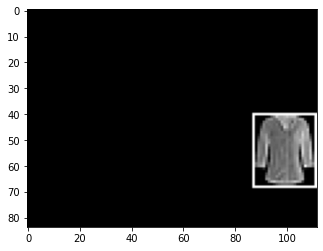

In [119]:
# 2nd item (21~41)
start_point = 21

# load raw image data
image_test_02346_raw = image_import(gt_test_02346, IMAGE_NAME_TEST_02346_RAW)/255.

# initial image with bounding box
x_tl = -8
y_tl = 40
x_br = 16
y_br = 68
img = image_test_02346_raw[start_point][0].cpu().detach().numpy()
cv2.rectangle(img,(x_tl, y_tl),(x_br,y_br),(1,0,0),1)
plt.imshow(img, cmap='gray')
pause(0.1)

# updated image with bounding box
for i in range(19):
    # update bounding box position
    x_tl += x2[i][0].cpu().detach().item()
    y_tl += x2[i][1].cpu().detach().item()
    x_br += x2[i][0].cpu().detach().item()
    y_br += x2[i][1].cpu().detach().item()
    # plot img with bounding box
    img = image_test_02346_raw[start_point+i+1][0].cpu().detach().numpy()
    cv2.rectangle(img,(x_tl, y_tl),(x_br,y_br),(1,0,0),1)
    plt.imshow(img, cmap='gray')
    pause(0.1)

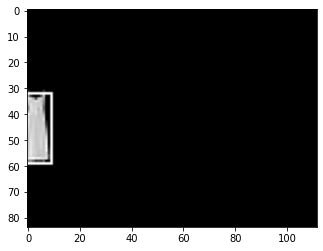

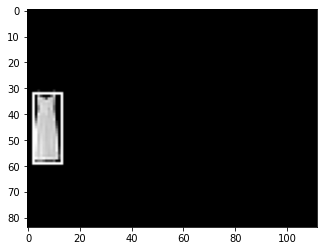

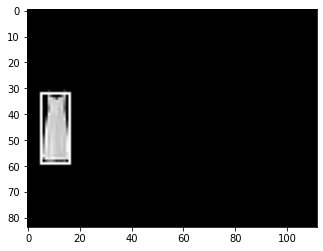

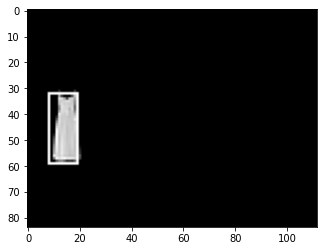

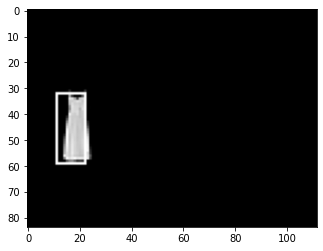

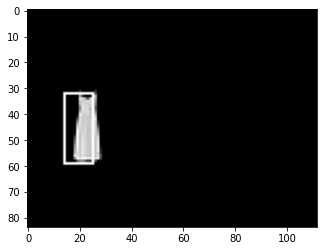

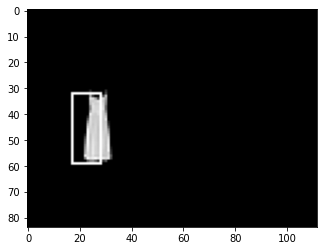

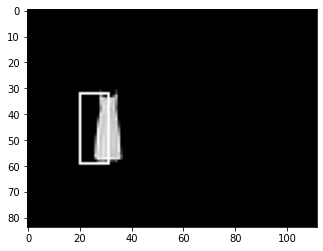

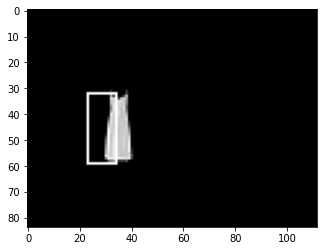

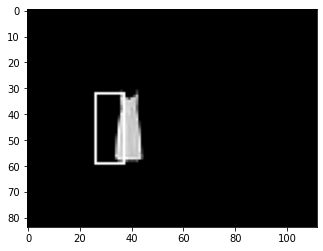

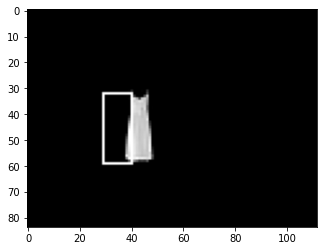

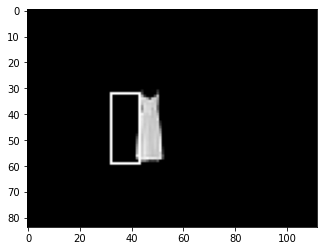

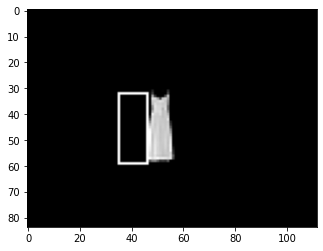

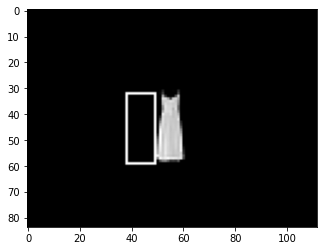

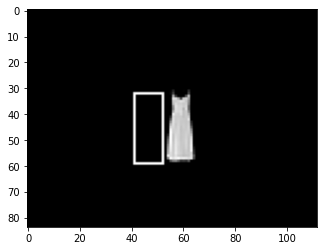

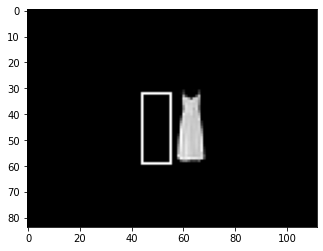

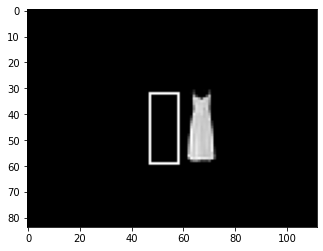

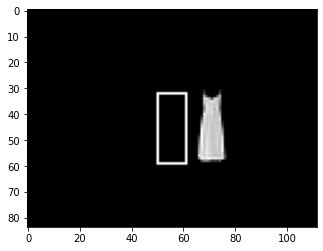

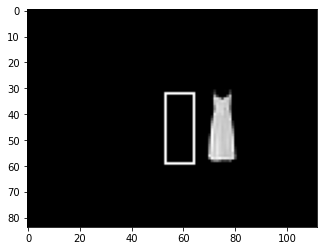

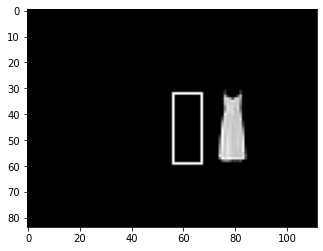

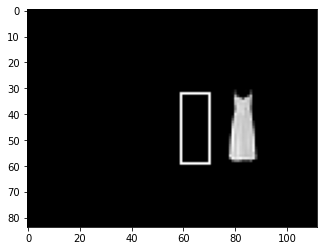

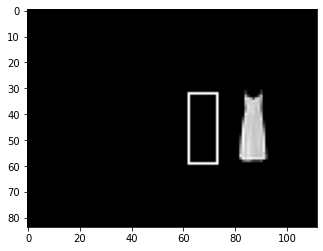

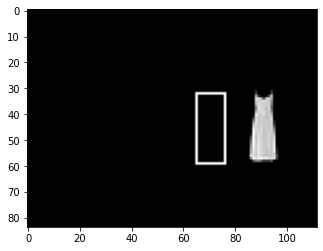

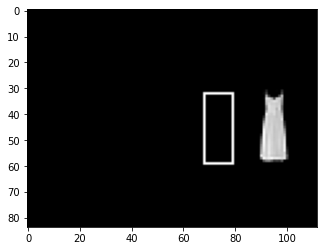

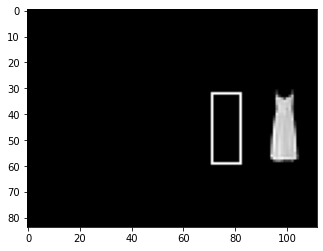

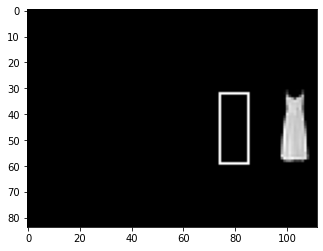

In [109]:
# 6th item (102~127)
start_point = 102

# load raw image data
image_test_02346_raw = image_import(gt_test_02346, IMAGE_NAME_TEST_02346_RAW)/255.

# initial image with bounding box
x_tl = -2
y_tl = 32
x_br = 9
y_br = 59
img = image_test_02346_raw[start_point][0].cpu().detach().numpy()
cv2.rectangle(img,(x_tl, y_tl),(x_br,y_br),(1,0,0),1)
plt.imshow(img, cmap='gray')
pause(0.1)

# updated image with bounding box
for i in range(25):
    # update bounding box position
    x_tl += x6[i][0].cpu().detach().item()
    y_tl += x6[i][1].cpu().detach().item()
    x_br += x6[i][0].cpu().detach().item()
    y_br += x6[i][1].cpu().detach().item()
    # plot img with bounding box
    img = image_test_02346_raw[start_point+i+1][0].cpu().detach().numpy()
    cv2.rectangle(img,(x_tl, y_tl),(x_br,y_br),(1,0,0),1)
    plt.imshow(img, cmap='gray')
    pause(0.1)